In [6]:
%run "C:\Users\adity\Downloads\Functions App Latest\Functions App\Dependencies.ipynb"

In [7]:
class CowoFunction:
    MOST_FREQUENT_TERMS = 2000

    def __init__(self):
        self.map_result_lemmatization: Dict[int, str] = {}
        self.flatten_to_ascii = False
        self.skip_content_in_parentheses = False
        self.remove_leaves = False
        self.session_id = ""
        self.callback_url = ""
        self.data_persistence_id = ""

    def set_flatten_to_ascii(self, flatten_to_ascii: bool) -> None:
        self.flatten_to_ascii = flatten_to_ascii

    def set_session_id_and_callback_url(self, session_id: str, callback_url: str, data_persistence_id: str) -> None:
        self.session_id = session_id
        self.callback_url = callback_url
        self.data_persistence_id = data_persistence_id


    def analyze(self, map_of_lines: Dict[int, str], lang: str, user_supplied_stopwords: Set[str], min_char_number: int,
                replace_stopwords: bool, scientific: bool, remove_accents: bool, min_cooc_freq: int,
                min_term_freq: int, correction: str, max_ngram: int, lemmatize: bool) -> str:

        dm = DataManager()

        # Perform text cleaning operations
        intermediary_map = TextCleaningOps.do_all_cleaning_ops_with_optional_ascii(map_of_lines, remove_accents)
        intermediary_map = TextCleaningOps.put_in_lower_case_map(intermediary_map)
        map_tree = dict(sorted(intermediary_map.items()))  # Using a sorted dictionary as a substitute for TreeMap

        # Set the cleaned map of lines in the data model
        dm.set_map_of_lines(map_tree)


        print("🪓 starting tokenization")

        UmigonTokenizer.initialize()

        for key, value in dm.get_original_strings_per_line().items():
            # Tokenize the input string
            tokenized = UmigonTokenizer.tokenize(value.lower().strip(), set())

            # Handle parentheses content and check for lowercase characters
            if self.skip_content_in_parentheses and len(tokenized) >= 2:
                first = tokenized[0]
                last = tokenized[-1]

                # Check if the tokenized content starts with "(" and ends with ")"
                if not (first == "(" and last == ")"):
                    dm.get_text_fragments_per_line()[key] = tokenized
                else:
                    # Concatenate all tokenized fragments into a single string
                    s = ''.join(str(tf) for tf in tokenized)

                    # Check if there are no lowercase characters in the tokenized string
                    if not any(c.islower() for c in s):
                        dm.get_text_fragments_per_line()[key] = tokenized
            else:
                # Directly add the tokenized content to the text fragments map
                dm.get_text_fragments_per_line()[key] = tokenized



        print("🖇️ entering ngram addition")

        for key, text_fragments in dm.get_text_fragments_per_line().items():
            stringified_ngrams = set()
            ngrams_for_one_line = []

            sentence_detector = SentenceLikeFragmentsDetector()
            sentence_like_fragments = sentence_detector.return_sentence_like_fragments(text_fragments)

            for sentence_like_fragment in sentence_like_fragments:
                ngrams = NGramFinderBisForTextFragments.generate_ngrams_upto(sentence_like_fragment.get_ngrams(), max_ngram)
                sentence_like_fragment.set_ngrams(ngrams)
                ngrams_for_one_line.extend(ngrams)

            # Removing n-grams that appear several times in a given line
            ngrams_for_uniqueness_test = set()
            for ngram in ngrams_for_one_line:
                stringified_ngram = ngram.get_cleaned_and_stripped_ngram_if_condition(self.flatten_to_ascii)
                if stringified_ngram not in ngrams_for_uniqueness_test:
                    ngrams_for_uniqueness_test.add(stringified_ngram)
                    dm.get_list_of_n_grams_global().append(ngram)
                    stringified_ngrams.add(stringified_ngram)

            dm.get_cleaned_and_stripped_ngrams_per_line()[key] = stringified_ngrams


        # Stopwords removal initialization
        print("🧹 initializing the stopword removal")

        stop_words_remover = StopWordsRemover(min_char_number, lang)

        # Check and add user-supplied stopwords if provided
        if user_supplied_stopwords:
            stop_words_remover.use_user_supplied_stopwords(user_supplied_stopwords, replace_stopwords)

        # Add scientific stopwords based on the language and corpus type
        if scientific:
            if lang == "en":
                scientific_stopwords_in_english = Stopwords.get_scientific_stopwords_in_english()
                stop_words_remover.add_field_specific_stop_words(scientific_stopwords_in_english)
            elif lang == "fr":
                scientific_stopwords_in_french = Stopwords.get_scientific_stopwords_in_french()
                stop_words_remover.add_field_specific_stop_words(scientific_stopwords_in_french)

        # Add empty sets for words to remove and stopwords to keep
        stop_words_remover.add_words_to_remove(set())
        stop_words_remover.add_stop_words_to_keep(set())

        # Remove redundant n-grams
        print("➿ creating a multiset to remove redundant ngrams")
        multiset_of_ngrams_so_far_stringified = Multiset()

        for ngram in dm.get_list_of_n_grams_global():
            ngram_string = ngram.get_cleaned_and_stripped_ngram_if_condition(self.flatten_to_ascii)
            multiset_of_ngrams_so_far_stringified.add_one(ngram_string)

        # Remove infrequent n-grams
        size = multiset_of_ngrams_so_far_stringified.get_size()

        if size < 10_000:
            min_occ = min(1, min_term_freq)
        elif size < 20_000:
            min_occ = min(2, min_term_freq)
        elif size < 30_000:
            min_occ = min(3, min_term_freq)
        elif size < 50_000:
            min_occ = min(4, min_term_freq)
        else:
            min_occ = min(5, min_term_freq)

        # Remove entries from the internal map if their frequency is less than min_occ

        internal_map = multiset_of_ngrams_so_far_stringified.get_internal_map()
        internal_map = {k: v for k, v in internal_map.items() if v >= min_occ}

        # Update the internal map after removal
        multiset_of_ngrams_so_far_stringified.set_internal_map(internal_map)

        print("➿ doing the redundant ngrams removal")
        stopwords = Stopwords.get_stop_words(lang).get("long")
        cleaner = NGramDuplicatesCleaner(stopwords)
        good_set_without_duplicates = cleaner.remove_duplicates(multiset_of_ngrams_so_far_stringified.get_internal_map(), 2, False)
        strings_to_keep = set(good_set_without_duplicates.keys())
        ngrams_to_keep = [ngram for ngram in dm.get_list_of_n_grams_global() if ngram.get_cleaned_and_stripped_ngram_if_condition(self.flatten_to_ascii) in strings_to_keep]
        dm.set_list_of_n_grams_global(ngrams_to_keep)

        print("🗑️ removing stopwords (1)")

        # Filter out n-grams based on stopwords removal
        filtered_ngrams = [
            ngram for ngram in dm.get_list_of_n_grams_global()
            if not stop_words_remover.should_it_be_removed(ngram.get_cleaned_and_stripped_ngram_if_condition(self.flatten_to_ascii))
            and not stop_words_remover.should_it_be_removed(ngram.get_cleaned_and_stripped_ngram_if_condition(False))
        ]

        dm.set_list_of_n_grams_global(filtered_ngrams)

        print("🧢 capping to 10_000 most frequent ngrams")
        multiset_to_cap = Multiset()
        multiset_to_cap.add_all_from_list_or_set(dm.get_list_of_n_grams_global())
        most_frequent_ngrams = multiset_to_cap.keep_most_frequent(multiset_to_cap, 10000)
        dm.set_list_of_n_grams_global(most_frequent_ngrams.to_list_of_all_occurrences())

        print("💇 entering lemmatization")
        if not lemmatize:
            for ngram in dm.get_list_of_n_grams_global():
                non_lemmatized_ngram = ngram.get_cleaned_and_stripped_ngram_if_condition(self.flatten_to_ascii)
                ngram.set_original_form_lemmatized(non_lemmatized_ngram)
        else:
            map_input_cleaned_and_stripped = {}
            candidates_to_lemmatization = set()

            for ngram in dm.get_list_of_n_grams_global():
                candidates_to_lemmatization.add(ngram.get_cleaned_and_stripped_ngram_if_condition(self.flatten_to_ascii))

            map_input_cleaned_and_stripped = {i: s for i, s in enumerate(candidates_to_lemmatization)}

            # Initialize the Lemmatizer based on the language
            if lang in ["en", "fr", "es"]:
                lemmatizer = Lemmatizer(lang)

                map_result_lemmatization = {}
                for key, input_ngram in map_input_cleaned_and_stripped.items():
                    lemmatized_ngram = lemmatizer.lemmatize(input_ngram)
                    map_result_lemmatization[key] = lemmatized_ngram
            else:
                print(f"Lemmatizer for language '{lang}' is not supported.")
                map_result_lemmatization = {}

            print("💇 finishing up lemmatization")
            stringified_cleaned_and_stripped_ngram_to_lemmatized_form = {}

            for key, input_ngram in map_input_cleaned_and_stripped.items():
                output_ngram = map_result_lemmatization.get(key, input_ngram)
                stringified_cleaned_and_stripped_ngram_to_lemmatized_form[input_ngram] = output_ngram

            for ngram in dm.get_list_of_n_grams_global():
                stringified_ngram = ngram.get_cleaned_and_stripped_ngram_if_condition(self.flatten_to_ascii)
                lemmatized_form = stringified_cleaned_and_stripped_ngram_to_lemmatized_form.get(stringified_ngram, stringified_ngram)
                ngram.set_original_form_lemmatized(lemmatized_form)

        print("🧺 second round of stopwords removal")
        ngrams_global = [
            ngram for ngram in dm.get_list_of_n_grams_global()
            if not stop_words_remover.should_it_be_removed(ngram.get_original_form_lemmatized())
        ]

        dm.set_list_of_n_grams_global(ngrams_global)

        print("✏️ removal of small words and digits")
        if min_term_freq:
            ngrams_global = [
                ngram for ngram in ngrams_global
                if len(ngram.get_original_form_lemmatized()) > min_char_number
                and not any(c.isdigit() for c in ngram.get_original_form_lemmatized())
            ]

            dm.set_list_of_n_grams_global(ngrams_global)

        print("🖩 counting ngrams, merging lemmatized and non-lemmatized versions, keeping only the top terms")
        ngrams_and_counts = Counter(dm.get_list_of_n_grams_global())

        ngrams = dm.get_list_of_n_grams_global()
        ngram_counts = Counter(ngrams)

        merged_counts = {}
        for ngram, count in ngram_counts.items():
            key = ngram.original_form_lemmatized
            merged_counts[key] = merged_counts.get(key, 0) + count

        deduplicated_map = {
            next(ng for ng in ngram_counts if ng.original_form_lemmatized == key): count
            for key, count in merged_counts.items()
        }

        filtered_sorted_entries = {
            ngram: count
            for ngram, count in sorted(
                deduplicated_map.items(),
                key=itemgetter(1),
                reverse=True
            )
            if count >= min_term_freq
        }

        top_entries = dict(list(filtered_sorted_entries.items())[:self.MOST_FREQUENT_TERMS])
        dm.set_n_grams_and_global_count(top_entries)

        print("🧠 calculating cooccurrences")

        list_cooc_total = Multiset()
        cleaned_and_stripped_to_ngram: Dict[str, NGram] = {}
        lemmatized_to_ngram: Dict[str, NGram] = {}

        for ngram in dm.get_n_grams_and_global_count().keys():
            cleaned_and_stripped_to_ngram[ngram.get_cleaned_and_stripped_ngram_if_condition(self.flatten_to_ascii)] = ngram
            lemmatized_to_ngram[ngram.get_original_form_lemmatized()] = ngram

        for entry in dm.get_cleaned_and_stripped_ngrams_per_line().items():
            cleaned_and_stripped_stringified_ngrams_for_one_line = entry[1]
            ngrams_in_current_line: Dict[str, NGram] = {}

            for one_ngram_for_one_line in cleaned_and_stripped_stringified_ngrams_for_one_line:
                if one_ngram_for_one_line in cleaned_and_stripped_to_ngram:
                    ngram_found = cleaned_and_stripped_to_ngram[one_ngram_for_one_line]
                    ngrams_in_current_line[ngram_found.get_original_form_lemmatized()] = ngram_found
                elif one_ngram_for_one_line in lemmatized_to_ngram:
                    ngram_found = lemmatized_to_ngram[one_ngram_for_one_line]
                    ngrams_in_current_line[ngram_found.get_original_form_lemmatized()] = ngram_found

            if len(ngrams_in_current_line) > 1:
                array_ngram = list(ngrams_in_current_line.values())
                try:
                    coocs = PerformCombinationsOnNGrams(array_ngram).call()
                    list_cooc_total.add_all_from_list_or_set(coocs)
                except Exception as ex:
                    print(f"Exception occurred: {ex}")


        print("🧹 removing infrequent cooc")
        nb_coocs = list_cooc_total.get_size()

        # Determine minimum co-occurrence frequency based on the total number of co-occurrences
        if nb_coocs < 50_000:
            min_cooc_freq = 1
        elif nb_coocs < 80_000:
            min_cooc_freq = 2
        elif nb_coocs < 110_000:
            min_cooc_freq = 3
        else:
            min_cooc_freq = 4

        # Filter and sort co-occurrences based on the minimum frequency
        sort_desc_keep_above_min_freq = list_cooc_total.sort_desc_keep_above_min_freq(list_cooc_total, min_cooc_freq)
        coocs_stringified = Multiset()
        nodes_in_edges_stringified = Multiset()
        coocs = Multiset()

        # Add filtered and sorted co-occurrences to the multisets
        for entry in sort_desc_keep_above_min_freq:
            coocs_stringified.add_several(str(entry[0]), entry[1])
            coocs.add_several(entry[0], entry[1])
            nodes_in_edges_stringified.add_one(entry[0].a.get_original_form_lemmatized())
            nodes_in_edges_stringified.add_one(entry[0].b.get_original_form_lemmatized())

        # Calculate number of nodes and edges
        number_of_nodes = len(nodes_in_edges_stringified.get_element_set())
        number_of_edges = len(coocs_stringified.get_element_set())

        print("Number of Nodes : ", number_of_nodes)
        print("Number of Edges : ", number_of_edges)

        # Check if the number of edges is too high relative to the number of nodes
        if number_of_edges > 50_000 and number_of_edges > (number_of_nodes * 50):
            too_many_edges = True
        else:
            too_many_edges = False

        if too_many_edges:
            max_number_edges_int = number_of_nodes * 50
            sort_desc_keep_most_frequent = coocs.sort_desc_keep_most_frequent(max_number_edges_int)

            coocs = Multiset()
            nodes_in_edges_stringified = Multiset()

            # Add most frequent co-occurrences to the multisets
            for entry in sort_desc_keep_most_frequent:
                coocs.add_several(entry[0], entry[1])
                nodes_in_edges_stringified.add_one(entry[0].a.get_original_form_lemmatized())
                nodes_in_edges_stringified.add_one(entry[0].b.get_original_form_lemmatized())


        print("⚽ adding nodes to graph")
        # Initialize graph and node attributes
        G = nx.Graph()
        nodes_map = {}
        removed_nodes = set()

        # Process the nodes
        element_set = nodes_in_edges_stringified.get_element_set()

        for ngram, count in dm.get_n_grams_and_global_count().items():
            node_label = ngram.get_original_form_lemmatized()

            # Not including isolated nodes
            if node_label not in element_set:
                removed_nodes.add(node_label)
                continue

            # Remove leaves if specified
            if self.remove_leaves and nodes_in_edges_stringified.get_count(node_label) == 1:
                removed_nodes.add(node_label)
                continue

            if count < min_term_freq:
                print(f"error with term {node_label}")
                print(f"freq {count}")
                continue

            # Add node to graph
            G.add_node(node_label, count_terms=count)
            nodes_map[node_label] = node_label


        print("🔗 adding edges to graph")
        # Initialize variables for edge weight calculations
        max_value_pmi = 0.00001
        max_value_count_edges = 0
        edges_and_their_pmi_weights_before_rescaling = {}
        edges_for_graph = set()

        # Loop through all co-occurrences to compute their PMI
        for cooc in coocs.get_element_set():
            if (cooc.a.get_original_form_lemmatized() in removed_nodes or
                cooc.b.get_original_form_lemmatized() in removed_nodes):
                continue

            count_edge = coocs_stringified.get_count(str(cooc))
            freq_source = dm.get_n_grams_and_global_count().get(cooc.a)
            freq_target = dm.get_n_grams_and_global_count().get(cooc.b)

            # Calculate edge weight PMI
            edge_weight_pmi = count_edge / (freq_source * freq_target)
            if edge_weight_pmi > max_value_pmi:
                max_value_pmi = edge_weight_pmi

            edges_and_their_pmi_weights_before_rescaling[str(cooc)] = edge_weight_pmi

            # Record the highest edge count
            if count_edge > max_value_count_edges:
                max_value_count_edges = count_edge

        # Rescale edge weights from 0 to 10 and add edges to the graph
        for cooc in coocs.get_element_set():
            if (cooc.a.get_original_form_lemmatized() in removed_nodes or
                cooc.b.get_original_form_lemmatized() in removed_nodes):
                continue

            count_edge = coocs_stringified.get_count(str(cooc))
            edge_weight_before_rescaling = 0
            type_correction = correction

            if type_correction == "pmi":
                edge_weight_before_rescaling = edges_and_their_pmi_weights_before_rescaling.get(str(cooc), 0)
                edge_weight_rescaled_to_ten = (edge_weight_before_rescaling * 10) / max_value_pmi
            elif type_correction == "none":
                edge_weight_before_rescaling = count_edge
                edge_weight_rescaled_to_ten = (edge_weight_before_rescaling * 10) / max_value_count_edges
            else:
                edge_weight_before_rescaling = count_edge
                edge_weight_rescaled_to_ten = (edge_weight_before_rescaling * 10) / max_value_count_edges

            source_label = cooc.a.get_original_form_lemmatized()
            target_label = cooc.b.get_original_form_lemmatized()

            node_source = nodes_map.get(source_label)
            node_target = nodes_map.get(target_label)

            if node_source and node_target:
                G.add_edge(node_source, node_target, weight=edge_weight_rescaled_to_ten, count_pairs=count_edge)

                if type_correction == "pmi":
                    G[node_source][node_target]['pmi'] = float(edge_weight_before_rescaling)

        return G

🪓 starting tokenization
🖇️ entering ngram addition
🧹 initializing the stopword removal
➿ creating a multiset to remove redundant ngrams
➿ doing the redundant ngrams removal
🗑️ removing stopwords (1)
🧢 capping to 10_000 most frequent ngrams
💇 entering lemmatization
🧺 second round of stopwords removal
✏️ removal of small words and digits
🖩 counting ngrams, merging lemmatized and non-lemmatized versions, keeping only the top terms
🧠 calculating cooccurrences
🧹 removing infrequent cooc
Number of Nodes :  17
Number of Edges :  43
⚽ adding nodes to graph
🔗 adding edges to graph


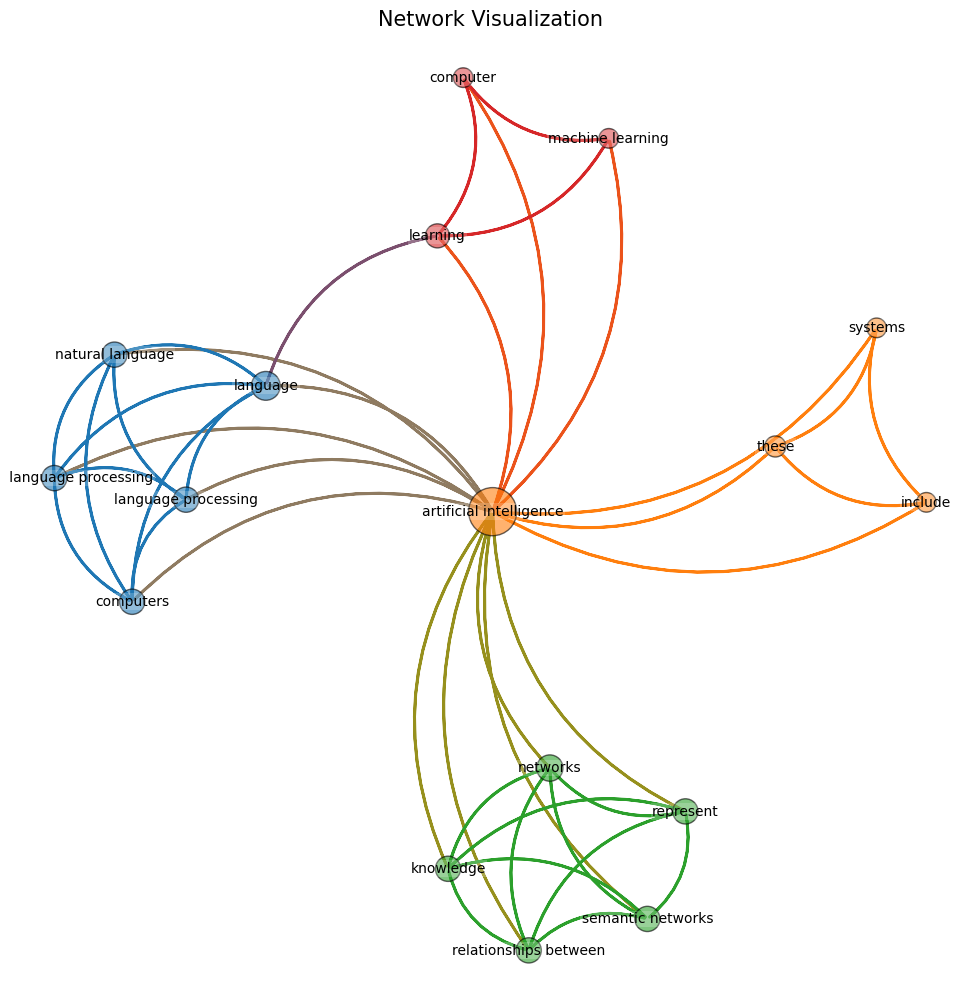

In [10]:
def main():
    # Assuming CowoFunction and write_vos_json are defined elsewhere
    cowo = CowoFunction()

    path = Path(r"C:\Users\adity\Downloads\Functions App Latest\Functions App\sample.txt")

    # Read lines from file
    with path.open(encoding='ISO-8859-1') as file:
        read_all_lines = file.readlines()

    map_of_lines = {i: line for i, line in enumerate(read_all_lines)}

    # Set parameters
    cowo.set_flatten_to_ascii(False)
    lang = "en"
    min_char_number = 4
    replace_stopwords = False
    scientific = False
    remove_accents = False
    min_term_freq = 2
    user_supplied_stopwords = set()
    min_cooc_freq = 1
    correction = "none"
    max_ngram = 4
    lemmatize = False
    seed = 42

    # Analyze and write to file
    G = cowo.analyze(
        map_of_lines, lang, user_supplied_stopwords, min_char_number, replace_stopwords, scientific,
        remove_accents, min_cooc_freq, min_term_freq, correction, max_ngram, lemmatize
    )

    # Save the graph as JSON
    write_vos_json(G, "ngram_cooccurrence_network.json")

    # Path to your JSON file
    file_path = 'ngram_cooccurrence_network.json'

    # Read the JSON file and convert it to a Python dictionary
    with open(file_path, 'r') as file:
        data = json.load(file)


    # Create the graph
    G = nx.Graph()
    for item in data['network']['items']:
        G.add_node(item['id'], label=item['label'])
    for link in data['network']['links']:
        G.add_edge(link['source_id'], link['target_id'], weight=link['strength'])

    # Calculate node sizes
    node_sizes = calculate_node_sizes(G)

    # Perform Louvain clustering with resolution parameter
    resolution = 0.8  # Adjust resolution to fine-tune clustering
    clusters = community_louvain.best_partition(G, weight='weight', resolution=resolution)

    # Create similarity matrix and apply MDS
    similarity_matrix, node_index = create_similarity_matrix(G)
    pos = apply_mds(similarity_matrix)

    # Prepare output JSON with positions, sizes, and clusters
    processed_data = {
        "network": {
            "items": [],
            "links": data['network']['links']
        }
    }

    for node, idx in node_index.items():
        processed_data["network"]["items"].append({
            "id": node,
            "label": G.nodes[node]["label"],
            "x": pos[idx, 0],
            "y": pos[idx, 1],
            "cluster": clusters[node],
            "weights": {
                "countTerms": int(node_sizes[node])
            },
            "scores": {
                "viz_size": 10  # You can adjust this value as needed
            }
        })


    # Create the graph from the JSON data
    G = CurvedEdge.create_graph_from_json(processed_data)

    # Visualize the graph and get the figure object
    fig = CurvedEdge.visualize_graph_to_variable(G, seed)

    # Display the figure
    plt.show()  # This will display the plot

if __name__ == "__main__":
    main()
